# Getting started: Monte Carlo simulation of intensity modulation direct-detection (IM/DD) with On-Off Keying (OOK)

## Single Monte Carlo run

In [1]:
import numpy as np
from optic.models.devices import mzm, photodiode
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import modulateGray
from optic.comm.metrics import bert
from optic.dsp.core import firFilter, pulseShape, upsample, pnorm
from optic.utils import parameters, dBm2W
from scipy.special import erfc
import matplotlib.pyplot as plt

In [2]:
# simulation parameters
SpS = 16  # samples per symbol
M = 2  # order of the modulation format
Rs = 10e9  # Symbol rate
Fs = SpS * Rs  # Signal sampling frequency (samples/second)
Pi_dBm = 3  # laser optical power at the input of the MZM in dBm
Pi = dBm2W(Pi_dBm)  # convert from dBm to W

# typical NRZ pulse
pulse = pulseShape("nrz", SpS)
pulse = pulse / max(abs(pulse))  # normalize to 1 Vpp

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi / 2

# linear fiber optical channel parameters
paramCh = parameters()
paramCh.L = 100        # total link distance [km]
paramCh.alpha = 0.2    # fiber loss parameter [dB/km]
paramCh.D = 16         # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs

# photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

In [3]:
## Simulation
print("\nStarting simulation...", end="")

# generate pseudo-random bit sequence
np.random.seed(seed=123)  # fixing the seed to get reproducible results
bitsTx = np.random.randint(2, size=100000)

# generate 2-PAM modulated symbol sequence
symbTx = modulateGray(bitsTx, M, "pam")

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)

# optical modulation
Ai = np.sqrt(Pi)  # ideal cw laser constant envelope
sigTxo = mzm(Ai, sigTx, paramMZM)

# linear fiber channel model
sigCh = linearFiberChannel(sigTxo, paramCh)

# noisy PD (thermal noise + shot noise + bandwidth limit)
I_Rx = photodiode(sigCh, paramPD)

# capture samples in the middle of signaling intervals
I_Rx = I_Rx[0::SpS]

# calculate the BER and Q-factor
BER, Q = bert(I_Rx)
print("simulation completed.")

print("\nTransmission performance metrics:")
print(f"Q-factor = {Q:.2f} ")
print(f"BER = {BER:.2e}")

# theoretical error probability from Q-factor
Pb = 0.5 * erfc(Q / np.sqrt(2))
print(f"Pb = {Pb:.2e}\n")


Starting simulation...simulation completed.

Transmission performance metrics:
Q-factor = 3.49 
BER = 2.80e-04
Pb = 2.44e-04



## Generating BER vs Pin Q vs Pin curves

In [4]:
# simulation parameters
SpS = 16        # Samples per symbol
M = 2           # order of the modulation format
Rs = 10e9       # Symbol rate (for the OOK case, Rs = Rb)
Fs = SpS*Rs     # Signal sampling frequency (samples/second)
Ts = 1/Fs       # Sampling period

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# linear fiber optical channel parameters
paramCh = parameters()
paramCh.L = 100  # total link distance [km]
paramCh.alpha = 0.2  # fiber loss parameter [dB/km]
paramCh.D = 16  # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs

# photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

In [5]:
powerValues = np.arange(-30, -9) # power values at the input of the pin receiver
distances = np.arange(100,160,10)

BER = np.zeros((len(distances), len(powerValues)))
Q = np.zeros((len(distances), len(powerValues)))

In [6]:
for indL, L in enumerate(distances):
    paramCh.L = L  # total link distance [km]
    for indPi, Pi_dBm in enumerate(powerValues):        
        Pi = dBm2W(Pi_dBm + L*paramCh.alpha + 3) # optical signal power in W at the MZM input

        # generate pseudo-random bit sequence
        np.random.seed(seed=123)  # fixing the seed to get reproducible results
        bitsTx = np.random.randint(2, size=10**5)
        n = np.arange(0, bitsTx.size)

        # generate ook modulated symbol sequence
        symbTx = modulateGray(bitsTx, M, 'pam')    
        symbTx = pnorm(symbTx) # power normalization

        # upsampling
        symbolsUp = upsample(symbTx, SpS)

        # pulse formatting
        sigTx = firFilter(pulse, symbolsUp)

        # optical modulation
        Ai = np.sqrt(Pi)
        sigTxo = mzm(Ai, sigTx, paramMZM)

        # linear fiber channel model
        sigCh = linearFiberChannel(sigTxo, paramCh)

        # pin receiver
        I_Rx = photodiode(sigCh.real, paramPD)
        I_Rx = I_Rx/np.std(I_Rx)

        # capture samples in the middle of signaling intervals
        I_Rx = I_Rx[0::SpS]

        # calculate the BER and Q-factor
        BER[indL, indPi], Q[indL, indPi] = bert(I_Rx)

        print(f'\nPin = {Pi_dBm:.2f} dBm')
        print('\nReceived signal parameters:')
        print(f'Q-factor = {Q[indL, indPi]:.2f} ')
        print(f'BER = {BER[indL, indPi]:.2e}')


Pin = -30.00 dBm

Received signal parameters:
Q-factor = 0.45 
BER = 3.28e-01

Pin = -29.00 dBm

Received signal parameters:
Q-factor = 0.56 
BER = 2.88e-01

Pin = -28.00 dBm

Received signal parameters:
Q-factor = 0.70 
BER = 2.41e-01

Pin = -27.00 dBm

Received signal parameters:
Q-factor = 0.88 
BER = 1.88e-01

Pin = -26.00 dBm

Received signal parameters:
Q-factor = 1.10 
BER = 1.34e-01

Pin = -25.00 dBm

Received signal parameters:
Q-factor = 1.38 
BER = 8.35e-02

Pin = -24.00 dBm

Received signal parameters:
Q-factor = 1.72 
BER = 4.30e-02

Pin = -23.00 dBm

Received signal parameters:
Q-factor = 2.13 
BER = 1.71e-02

Pin = -22.00 dBm

Received signal parameters:
Q-factor = 2.61 
BER = 4.69e-03

Pin = -21.00 dBm

Received signal parameters:
Q-factor = 3.16 
BER = 8.20e-04

Pin = -20.00 dBm

Received signal parameters:
Q-factor = 3.76 
BER = 9.00e-05

Pin = -19.00 dBm

Received signal parameters:
Q-factor = 4.39 
BER = 0.00e+00

Pin = -18.00 dBm

Received signal parameters:
Q-fac


Pin = -10.00 dBm

Received signal parameters:
Q-factor = 2.07 
BER = 6.68e-03

Pin = -30.00 dBm

Received signal parameters:
Q-factor = 0.30 
BER = 3.80e-01

Pin = -29.00 dBm

Received signal parameters:
Q-factor = 0.38 
BER = 3.52e-01

Pin = -28.00 dBm

Received signal parameters:
Q-factor = 0.47 
BER = 3.20e-01

Pin = -27.00 dBm

Received signal parameters:
Q-factor = 0.57 
BER = 2.83e-01

Pin = -26.00 dBm

Received signal parameters:
Q-factor = 0.70 
BER = 2.44e-01

Pin = -25.00 dBm

Received signal parameters:
Q-factor = 0.83 
BER = 2.05e-01

Pin = -24.00 dBm

Received signal parameters:
Q-factor = 0.97 
BER = 1.69e-01

Pin = -23.00 dBm

Received signal parameters:
Q-factor = 1.11 
BER = 1.38e-01

Pin = -22.00 dBm

Received signal parameters:
Q-factor = 1.24 
BER = 1.14e-01

Pin = -21.00 dBm

Received signal parameters:
Q-factor = 1.36 
BER = 9.83e-02

Pin = -20.00 dBm

Received signal parameters:
Q-factor = 1.45 
BER = 8.76e-02

Pin = -19.00 dBm

Received signal parameters:
Q-fac

C:\Users\edson\AppData\Local\Temp\ipykernel_2392\2042705777.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(Prx, np.log10(BER[indL,:]),'--', marker=markers[indL], label=f'{L} km')


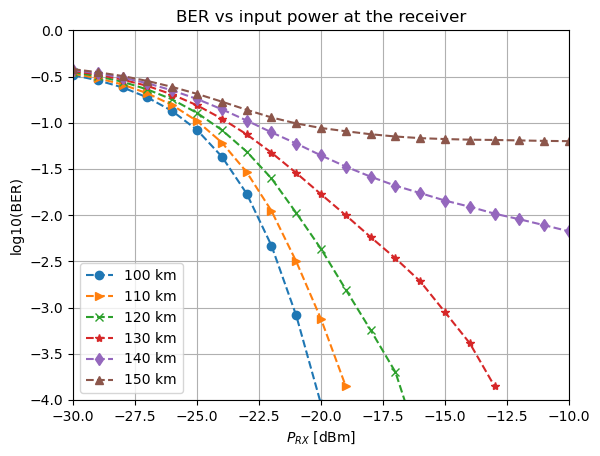

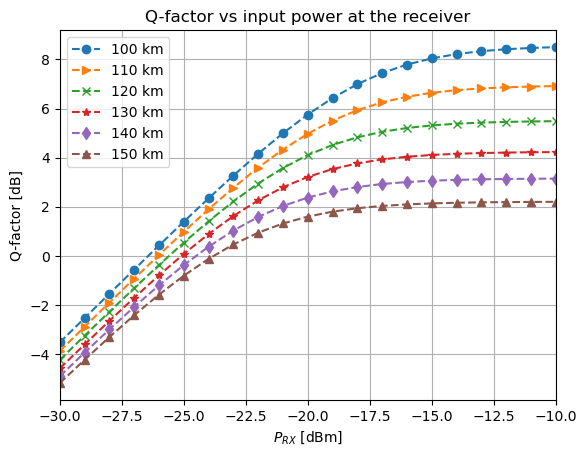

In [7]:
markers = ['o','>','x','*','d','^']

Prx = powerValues #- paramCh.L*paramCh.alpha

plt.figure()
for indL, L in enumerate(distances):
   # Prx = powerValues - L*paramCh.alpha
    plt.plot(Prx, np.log10(BER[indL,:]),'--', marker=markers[indL], label=f'{L} km')

plt.grid()
plt.ylabel('log10(BER)')
plt.xlabel('$P_{RX}$ [dBm]')
plt.title('BER vs input power at the receiver')
plt.legend()
plt.ylim(-4,0)
plt.xlim(min(Prx), max(Prx))
plt.show()

plt.figure()
for indL, L in enumerate(distances):
   # Prx = powerValues - L*paramCh.alpha
    plt.plot(Prx, 10*np.log10(Q[indL,:]),'--', marker=markers[indL], label=f'{L} km')

plt.grid()
plt.ylabel('Q-factor [dB]')
plt.xlabel('$P_{RX}$ [dBm]')
plt.title('Q-factor vs input power at the receiver')
plt.legend()
#plt.ylim(-10,0)
plt.xlim(min(Prx), max(Prx))
plt.show()